# Distance Calculation from Closest Object using Depth Estimation

This notebook demonstrates how to calculate the distance to the closest object in a scene using monocular depth estimation. This is particularly useful for obstacle avoidance in robotics, drone navigation, and safety applications.

<div style="text-align: center;">
  <figure style="display: inline-block;">
    <img src="https://learnopencv.com/wp-content/uploads/2024/02/animal-depth-anything-large.gif" alt="Distance Calculation from Closest Object" width = 900>
    <figcaption style="text-align: center;">Distance Calculation from Closest Object using Depth Estimation</figcaption>
  </figure>
</div>

## Key Features:
- Real-time depth estimation using DepthPro
- Distance calculation to the closest object
- Visual highlighting of the closest object region
- Interactive interface for testing with different images
- Conversion from depth values to real-world distances
- Safety zone visualization for obstacle avoidance


<a href="https://colab.research.google.com/github/ShudarshanKongkham/AgenticDrone_Basic/blob/main/Distance_from_Closest_Object.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## 1. Setup and Dependencies


In [1]:
%%capture
!git clone https://github.com/apple/ml-depth-pro.git
%cd ml-depth-pro
!pip install -e .


In [2]:
# Download the model checkpoint from huggingface
%%capture
!pip install huggingface-hub
!pip install gradio
!huggingface-cli download --local-dir checkpoints apple/DepthPro
%cd ..


In [3]:
# To avoid depth pro import errors
!pip install numpy==1.26.4


📌 **Restart Session** after installing dependencies


In [4]:
%ls

checkpoints@  distance_results/  input_images/  ml-depth-pro/  sample_data/


In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict
import time
import torch
import gradio as gr
from scipy import ndimage

# Add the src path for depth_pro
sys.path.append('ml-depth-pro/src')
!ln -s ml-depth-pro/checkpoints ./checkpoints # create a symbolic link to manage relative paths

os.makedirs("input_images", exist_ok=True)
os.makedirs("distance_results", exist_ok=True)

import warnings
warnings.filterwarnings('ignore')


In [2]:
import depth_pro

# Load model and preprocessing transform
model, transform = depth_pro.create_model_and_transforms(precision=torch.half)
model.to("cuda").eval()
print("DepthPro Model Loaded Successfully...✅")


DepthPro Model Loaded Successfully...✅


## 2. Core Distance Calculation Functions


In [5]:
def predict_depth_with_distance(rgb_image: np.ndarray) -> Tuple[np.ndarray, float, Dict]:
    """
    Predict depth map and calculate distance to closest object

    Args:
        rgb_image: Input RGB image

    Returns:
        depth_map: Normalized depth map for visualization
        min_distance: Distance to closest object in meters
        stats: Dictionary with depth statistics
    """
    # Prepare image for model
    image = transform(rgb_image).to("cuda")

    # Get depth prediction
    with torch.no_grad():
        prediction = model.infer(image)
        depth = prediction["depth"].detach().cpu().numpy().squeeze()

    # Calculate distance statistics
    min_distance = float(depth.min())
    max_distance = float(depth.max())
    mean_distance = float(depth.mean())

    # Create normalized depth map for visualization
    depth_normalized = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    stats = {
        'min_distance': min_distance,
        'max_distance': max_distance,
        'mean_distance': mean_distance,
        'closest_object_pixels': np.sum(depth == depth.min())
    }

    return depth_normalized, min_distance, stats, depth


In [6]:
def find_closest_object_region(depth_map: np.ndarray, tolerance: float = 0.1) -> np.ndarray:
    """
    Find and highlight the region containing the closest object

    Args:
        depth_map: Raw depth map from model
        tolerance: Distance tolerance for grouping closest pixels

    Returns:
        mask: Binary mask highlighting closest object region
    """
    min_depth = depth_map.min()

    # Create mask for pixels within tolerance of minimum depth
    closest_mask = depth_map <= (min_depth + tolerance)

    # Apply morphological operations to clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    closest_mask = cv2.morphologyEx(closest_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    closest_mask = cv2.morphologyEx(closest_mask, cv2.MORPH_OPEN, kernel)

    return closest_mask.astype(bool)


In [7]:
def create_distance_visualization(rgb_image: np.ndarray, depth_map: np.ndarray,
                                min_distance: float, closest_mask: np.ndarray) -> np.ndarray:
    """
    Create a visualization showing the closest object highlighted

    Args:
        rgb_image: Original RGB image
        depth_map: Normalized depth map
        min_distance: Distance to closest object
        closest_mask: Mask highlighting closest object

    Returns:
        visualization: Combined visualization image
    """
    h, w = rgb_image.shape[:2]

    # Create overlay for closest object
    overlay = rgb_image.copy()
    overlay[closest_mask] = [0, 255, 0]  # Highlight in green

    # Blend with original image
    result = cv2.addWeighted(rgb_image, 0.7, overlay, 0.3, 0)

    # Add distance text
    text = f"Closest Object: {min_distance:.2f}m"
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.8
    thickness = 2

    # Get text size for background rectangle
    (text_width, text_height), _ = cv2.getTextSize(text, font, font_scale, thickness)

    # Draw background rectangle
    cv2.rectangle(result, (10, 10), (text_width + 20, text_height + 20), (0, 0, 0), -1)

    # Draw text
    cv2.putText(result, text, (15, text_height + 15), font, font_scale, (255, 255, 255), thickness)

    return result


## 3. Complete Processing Pipeline


In [8]:
def process_image_for_distance(rgb_image: np.ndarray) -> Tuple[np.ndarray, np.ndarray, str]:
    """
    Complete pipeline for distance calculation and visualization

    Args:
        rgb_image: Input RGB image

    Returns:
        depth_vis: Depth map visualization
        distance_vis: Distance visualization with highlighted closest object
        stats_text: Formatted statistics text
    """
    # Get depth prediction and distance calculation
    depth_normalized, min_distance, stats, raw_depth = predict_depth_with_distance(rgb_image)

    # Find closest object region
    closest_mask = find_closest_object_region(raw_depth)

    # Create visualizations
    distance_vis = create_distance_visualization(rgb_image, depth_normalized, min_distance, closest_mask)

    # Create depth visualization with colormap
    depth_colored = cv2.applyColorMap(depth_normalized, cv2.COLORMAP_PLASMA)

    # Format statistics
    stats_text = f"""
📏 Distance Statistics:
• Closest Object: {stats['min_distance']:.2f} meters
• Farthest Object: {stats['max_distance']:.2f} meters
• Average Distance: {stats['mean_distance']:.2f} meters
• Closest Object Area: {stats['closest_object_pixels']} pixels
    """

    return depth_colored, distance_vis, stats_text


## 4. Download Test Images


In [10]:
# Download test images
!wget https://learnopencv.com/wp-content/uploads/2025/04/Leopard-Cub.jpeg -O input_images/leopard.jpeg
!wget https://learnopencv.com/wp-content/uploads/2025/04/cave-scaled.jpg -O input_images/cave.jpg
!wget https://images.unsplash.com/photo-1506905925346-21bda4d32df4 -O input_images/mountain_road.jpg
!wget https://images.unsplash.com/photo-1551218808-94e220e084d2 -O input_images/office.jpg


--2025-06-11 13:49:28--  https://learnopencv.com/wp-content/uploads/2025/04/Leopard-Cub.jpeg
Resolving learnopencv.com (learnopencv.com)... 141.193.213.10, 141.193.213.11
Connecting to learnopencv.com (learnopencv.com)|141.193.213.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414619 (405K) [image/jpeg]
Saving to: ‘input_images/leopard.jpeg’

input_images/leopar 100%[===================>] 404.90K  1.82MB/s    in 0.2s    

2025-06-11 13:49:29 (1.82 MB/s) - ‘input_images/leopard.jpeg’ saved [414619/414619]

--2025-06-11 13:49:29--  https://learnopencv.com/wp-content/uploads/2025/04/cave-scaled.jpg
Resolving learnopencv.com (learnopencv.com)... 141.193.213.10, 141.193.213.11
Connecting to learnopencv.com (learnopencv.com)|141.193.213.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 682837 (667K) [image/jpeg]
Saving to: ‘input_images/cave.jpg’

input_images/cave.j 100%[===================>] 666.83K   806KB/s    in 0.8s    

2025-06-

## 5. Interactive Gradio Interface


In [11]:
# Global variables for storing processed data
stored_rgb = None
stored_depth = None
stored_stats = None

def analyze_distance(rgb_image):
    """Process image and return distance analysis"""
    global stored_rgb, stored_depth, stored_stats

    stored_rgb = rgb_image
    depth_vis, distance_vis, stats_text = process_image_for_distance(rgb_image)

    return depth_vis, distance_vis, stats_text

def update_tolerance(tolerance):
    """Update visualization with new tolerance value"""
    global stored_rgb

    if stored_rgb is not None:
        # Reprocess with new tolerance
        depth_normalized, min_distance, stats, raw_depth = predict_depth_with_distance(stored_rgb)
        closest_mask = find_closest_object_region(raw_depth, tolerance=tolerance)
        distance_vis = create_distance_visualization(stored_rgb, depth_normalized, min_distance, closest_mask)

        return distance_vis

    return None


In [12]:
# Create Gradio interface
with gr.Blocks(title="Distance from Closest Object") as demo:
    gr.Markdown("""
    # 🎯 Distance Calculation from Closest Object

    Upload an image to analyze the distance to the closest object using monocular depth estimation.
    The closest object will be highlighted in green, and distance statistics will be displayed.
    """)

    with gr.Tab("📸 Distance Analysis"):
        with gr.Row():
            with gr.Column():
                image_input = gr.Image(type="numpy", label="Upload Image")
                analyze_btn = gr.Button("🔍 Analyze Distance", variant="primary")

                gr.Markdown("### 🎛️ Adjustment Controls")
                tolerance_slider = gr.Slider(
                    minimum=0.01,
                    maximum=1.0,
                    value=0.1,
                    step=0.01,
                    label="Object Detection Tolerance (meters)",
                    info="Adjust how strictly to define the 'closest object'"
                )

            with gr.Column():
                depth_output = gr.Image(label="🌈 Depth Map Visualization")
                distance_output = gr.Image(label="🎯 Distance Analysis (Closest Object Highlighted)")

        with gr.Row():
            stats_output = gr.Textbox(
                label="📊 Distance Statistics",
                lines=6,
                interactive=False
            )

    with gr.Tab("ℹ️ About"):
        gr.Markdown("""
        ## How it works:

        1. **Depth Estimation**: Uses Apple's DepthPro model for monocular depth estimation
        2. **Distance Calculation**: Finds the minimum depth value to identify the closest object
        3. **Object Highlighting**: Creates a mask to highlight the region of the closest object
        4. **Visualization**: Overlays the results on the original image with distance information

        ## Applications:
        - 🚁 Drone obstacle avoidance
        - 🤖 Robot navigation
        - 🚗 Autonomous vehicle safety
        - 📱 AR/VR applications
        - 🎮 Gaming and simulation

        ## Tips:
        - **Tolerance**: Lower values = stricter definition of "closest object"
        - **Lighting**: Better lighting conditions improve depth estimation accuracy
        - **Scene Complexity**: Simple scenes with clear objects work best
        """)

    # Event handlers
    analyze_btn.click(
        fn=analyze_distance,
        inputs=image_input,
        outputs=[depth_output, distance_output, stats_output]
    )

    tolerance_slider.change(
        fn=update_tolerance,
        inputs=tolerance_slider,
        outputs=distance_output
    )

# Launch the interface
demo.launch(debug=True, share=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://df09d890470562aa75.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://df09d890470562aa75.gradio.live


## 6. Advanced Features and Safety Zones


In [21]:
def create_distance_heatmap(depth_map: np.ndarray) -> np.ndarray:
    """
    Create a distance heatmap visualization

    Args:
        depth_map: Raw depth map from model

    Returns:
        heatmap: Color-coded distance heatmap
    """
    # Normalize depth for visualization
    depth_norm = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Apply color map (closer = red, farther = blue)
    heatmap = cv2.applyColorMap(255 - depth_norm, cv2.COLORMAP_JET)

    return heatmap

def calculate_safety_zones(depth_map: np.ndarray, warning_distance: float = 2.0,
                          danger_distance: float = 1.0) -> Tuple[np.ndarray, Dict]:
    """
    Calculate safety zones based on distance thresholds

    Args:
        depth_map: Raw depth map
        warning_distance: Distance threshold for warning zone (meters)
        danger_distance: Distance threshold for danger zone (meters)

    Returns:
        safety_mask: Color-coded safety zones
        zone_stats: Statistics for each safety zone
    """
    h, w = depth_map.shape
    safety_mask = np.zeros((h, w, 3), dtype=np.uint8)

    # Define zones
    danger_zone = depth_map < danger_distance
    warning_zone = (depth_map >= danger_distance) & (depth_map < warning_distance)
    safe_zone = depth_map >= warning_distance

    # Color code zones
    safety_mask[danger_zone] = [0, 0, 255]    # Red - Danger
    safety_mask[warning_zone] = [0, 255, 255] # Yellow - Warning
    safety_mask[safe_zone] = [0, 255, 0]      # Green - Safe

    # Calculate statistics
    zone_stats = {
        'danger_pixels': np.sum(danger_zone),
        'warning_pixels': np.sum(warning_zone),
        'safe_pixels': np.sum(safe_zone),
        'danger_percentage': (np.sum(danger_zone) / (h * w)) * 100,
        'warning_percentage': (np.sum(warning_zone) / (h * w)) * 100,
        'safe_percentage': (np.sum(safe_zone) / (h * w)) * 100
    }

    return safety_mask, zone_stats


Processing image: input_images/Media.jpg


📏 Distance Statistics:
• Closest Object: 0.55 meters
• Farthest Object: 5.61 meters
• Average Distance: 1.70 meters
• Closest Object Area: 1 pixels
    


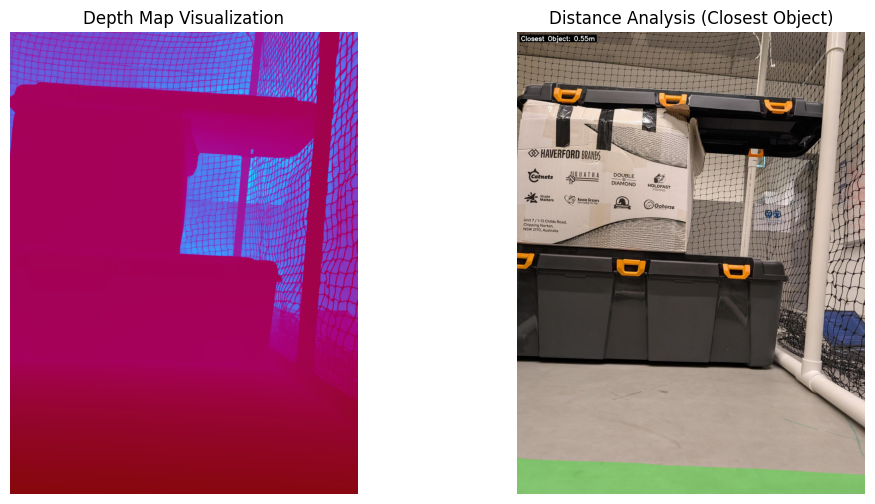

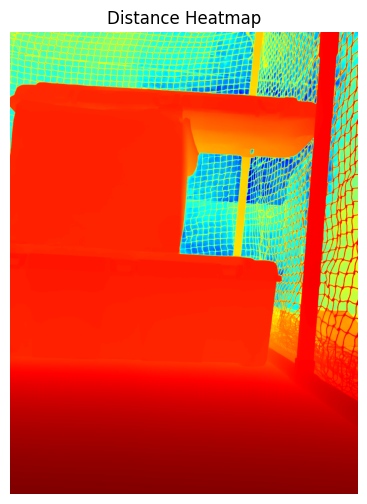


Safety Zone Statistics:
• danger Pixels: 486639.00
• warning Pixels: 1303721.00
• safe Pixels: 559750.00
• danger Percentage: 20.71%
• warning Percentage: 55.47%
• safe Percentage: 23.82%


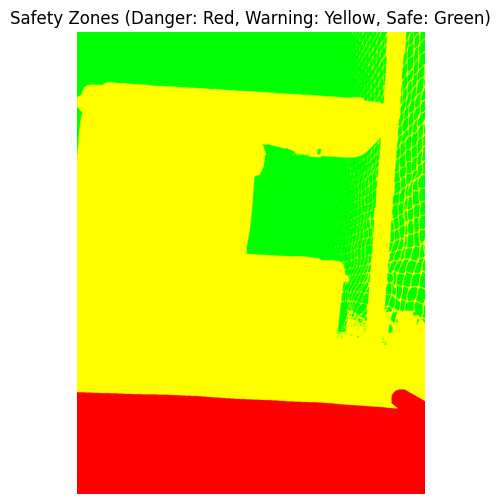

In [24]:
## 8. Inference on a Test Image

# Define the path to the test image you want to process
# You can change 'leopard.jpeg' to any image in your 'input_images' directory
image_path = "input_images/Media.jpg"

# Check if the image file exists
if not os.path.exists(image_path):
    print(f"Error: Image not found at {image_path}")
else:
    # Read the image using OpenCV
    # cv2.imread reads in BGR format by default
    bgr_image = cv2.imread(image_path)

    # Convert BGR image to RGB, as the model expects RGB input
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    print(f"Processing image: {image_path}")

    # Process the image using the complete pipeline function
    depth_vis, distance_vis, stats_text = process_image_for_distance(rgb_image)

    # Display the results
    print("\n" + stats_text)

    # Display the depth visualization using matplotlib
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(depth_vis)
    plt.title("Depth Map Visualization")
    plt.axis('off')

    # Display the distance analysis visualization using matplotlib
    plt.subplot(1, 2, 2)
    plt.imshow(distance_vis)
    plt.title("Distance Analysis (Closest Object)")
    plt.axis('off')

    plt.show()

    # Optionally, create and display the distance heatmap
    # The raw_depth is the fourth return value from predict_depth_with_distance
    # We need to call predict_depth_with_distance again or modify process_image_for_distance
    # to return raw_depth if we want to use the exact same processed depth.
    # For simplicity here, we'll re-run predict_depth_with_distance to get raw_depth
    # if you want to display the heatmap.

    _, _, _, raw_depth_for_heatmap = predict_depth_with_distance(rgb_image)
    heatmap_vis = create_distance_heatmap(raw_depth_for_heatmap)

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(heatmap_vis, cv2.COLOR_BGR2RGB)) # Convert BGR heatmap back to RGB for matplotlib
    plt.title("Distance Heatmap")
    plt.axis('off')
    plt.show()

    # Optionally, create and display safety zones
    safety_mask, zone_stats = calculate_safety_zones(raw_depth_for_heatmap, warning_distance=2.0, danger_distance=1.0)

    print("\nSafety Zone Statistics:")
    for zone, value in zone_stats.items():
        print(f"• {zone.replace('_pixels', ' Pixels').replace('_percentage', ' Percentage')}: {value:.2f}{'%' if 'percentage' in zone else ''}")

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(safety_mask, cv2.COLOR_BGR2RGB)) # Convert BGR safety mask back to RGB
    plt.title("Safety Zones (Danger: Red, Warning: Yellow, Safe: Green)")
    plt.axis('off')
    plt.show()

## 7. OpenCV Real-time Implementation (for Local Use)

For real-time applications like drone navigation or robotics, you can use this OpenCV implementation.
**Note**: This code is designed to run locally with a webcam.


In [ ]:
# Uncomment and run this code locally for real-time distance calculation with webcam

# import cv2
# import numpy as np
# import time

# def real_time_distance_detection():
#     """
#     Real-time distance detection using webcam
#     Press 'q' to quit, 's' to save current frame, 'h' for heatmap mode
#     """
#     cap = cv2.VideoCapture(0)  # Use webcam
#
#     if not cap.isOpened():
#         print("Error: Could not open webcam")
#         return
#
#     print("Starting real-time distance detection...")
#     print("Press 'q' to quit, 's' to save current frame, 'h' to toggle heatmap")
#
#     frame_count = 0
#     heatmap_mode = False
#
#     while True:
#         ret, frame = cap.read()
#         if not ret:
#             break
#
#         # Process every 5th frame to maintain reasonable speed
#         if frame_count % 5 == 0:
#             try:
#                 # Resize frame for faster processing
#                 small_frame = cv2.resize(frame, (640, 480))
#
#                 # Convert BGR to RGB
#                 rgb_frame = cv2.cvtColor(small_frame, cv2.COLOR_BGR2RGB)
#
#                 # Get depth prediction
#                 depth_normalized, min_distance, stats, raw_depth = predict_depth_with_distance(rgb_frame)
#
#                 if heatmap_mode:
#                     # Show distance heatmap
#                     heatmap = create_distance_heatmap(raw_depth)
#                     display_frame = heatmap
#                 else:
#                     # Show closest object analysis
#                     closest_mask = find_closest_object_region(raw_depth)
#                     distance_vis = create_distance_visualization(rgb_frame, depth_normalized, min_distance, closest_mask)
#                     display_frame = cv2.cvtColor(distance_vis, cv2.COLOR_RGB2BGR)
#
#                 # Add mode indicator
#                 mode_text = "Heatmap Mode" if heatmap_mode else "Distance Mode"
#                 cv2.putText(display_frame, mode_text, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
#
#                 # Resize back to original frame size
#                 display_frame = cv2.resize(display_frame, (frame.shape[1], frame.shape[0]))
#
#                 cv2.imshow('Real-time Distance Detection', display_frame)
#
#             except Exception as e:
#                 print(f"Processing error: {e}")
#                 cv2.imshow('Real-time Distance Detection', frame)
#         else:
#             cv2.imshow('Real-time Distance Detection', frame)
#
#         frame_count += 1
#
#         # Handle key presses
#         key = cv2.waitKey(1) & 0xFF
#         if key == ord('q'):
#             break
#         elif key == ord('s'):
#             # Save current frame
#             timestamp = int(time.time())
#             filename = f"distance_results/capture_{timestamp}.jpg"
#             cv2.imwrite(filename, display_frame)
#             print(f"Frame saved as {filename}")
#         elif key == ord('h'):
#             # Toggle heatmap mode
#             heatmap_mode = not heatmap_mode
#             print(f"Heatmap mode: {'ON' if heatmap_mode else 'OFF'}")
#
#     cap.release()
#     cv2.destroyAllWindows()
#     print("Real-time detection stopped.")

# # Uncomment to run real-time detection
# # real_time_distance_detection()


## 8. Conclusion and Applications

This notebook demonstrates how to calculate distances to the closest object using monocular depth estimation. The applications are vast and particularly valuable for autonomous systems:

### 🚁 **Drone Applications**:
- **Obstacle Avoidance**: Detect and avoid obstacles in real-time during flight
- **Landing Assistance**: Calculate distance to landing surfaces for safe landings
- **Navigation Safety**: Maintain safe distances from objects during autonomous flight
- **Indoor Navigation**: Navigate through buildings and confined spaces

### 🤖 **Robotics**:
- **Mobile Robot Navigation**: Path planning with obstacle awareness
- **Manipulation Tasks**: Distance feedback for robotic arms and grippers
- **Safety Systems**: Emergency stopping when objects are too close
- **Human-Robot Interaction**: Maintain safe distances from humans

### 🚗 **Autonomous Vehicles**:
- **Collision Avoidance**: Early warning systems for imminent collisions
- **Parking Assistance**: Distance to obstacles while parking
- **Lane Keeping**: Distance to lane boundaries and other vehicles
- **Emergency Braking**: Automatic braking when obstacles are detected

### 📱 **AR/VR Applications**:
- **Object Interaction**: Distance-based interaction in augmented reality
- **Spatial Mapping**: Understanding environment layout for virtual objects
- **Virtual Object Placement**: Realistic object positioning based on depth
- **Gaming**: Distance-based game mechanics and interactions

### 🏭 **Industrial Applications**:
- **Quality Control**: Distance measurements in manufacturing
- **Safety Monitoring**: Worker safety in industrial environments
- **Automated Inspection**: Distance-based quality assessment
- **Warehouse Robotics**: Navigation and object manipulation

### 🎯 **Key Advantages**:
- **Single Camera**: Works with just one camera (monocular depth estimation)
- **Real-time**: Can process video streams in real-time
- **Versatile**: Works in various lighting and environmental conditions
- **Cost-effective**: No need for expensive depth sensors like LiDAR
- **Portable**: Can run on mobile devices and embedded systems

The combination of deep learning-based depth estimation with traditional computer vision techniques provides a powerful tool for spatial understanding and safety applications across multiple domains.
